# ゼミ

    5月11日　太田　康之

## 報告内容
- 前回（4/28）の課題
    - amp_65の部分時系列について
        - モーメントを求める
            - 1次モーメントの期待値　平均値
            
            $$
            E(X) = \frac{1}{N} \displaystyle \sum_{i=1}^N X_i = \mu\tag{1}
            $$
            
            - 3次モーメントの期待値　歪度(分布の歪み具合を正規分布と比較する)
            - 4次モーメントの期待値　尖度（分布の尖り具合を正規分布と比較する）
            - 5次モーメントの期待値　（正規分布と比較する）
            - 6次モーメントの期待値　（正規分布と比較する）
            
            $$
            %\begin{align}
            \alpha _r = E\{(X-\mu)/\delta\}^r\tag{1}
            %\end{align}
            $$
           
           scipy.stats.moment(x, moment = n, axis = none, nan_policy = 'propagate' )を使ってn次モーメントの期待値を求める。
            
            $$
            %\begin{align}
            m_k = \frac{1}{n} \displaystyle \sum_{i=1}^n (x_i - \bar{ x })^k\tag{2} 
            %\end{align}
            $$
           
            $$
            %\begin{align}
            \alpha _5 = \frac{m_5}{{m_2}^{5/2}} = \frac{\frac{1}{n} \displaystyle \sum_{i=1}^n (x_i - \bar{ x })^6}{\{{\frac{1}{n} \displaystyle \sum_{i=1}^n (x_i - \bar{ x })^2}\}^{5/2}} \tag{3} 
            %\end{align}            
            $$
           
        - ノンパラメトリック検定
            - ウィルコクスン順位和検定
            - コルモゴロフ-スミルノフ検定
        - 適合度検定
        - 特異スペクトル変換法
            
            **井手・杉山,異常検知と変化検知,(2015) 部分空間法による変化検知**
           
         <!---img src = "image/book_ijoukenchi_henkakenchi_s.png" --->
         

## アドバイス頂きたいこと

- パターン抽出の手法について

    - 特異スペクトル変換法
<!--- img src ="image/fig_sindenzu_org.png" --->

<!--- img src ="image/fig_sindenzu_treat.png" --->

    - 計算コストを要する

# 取り扱うデータについて 

- 題材として製品Nから製品Cに切替えをおこなった際の時系列データについて分析を行った

日付|製品|（DATA）|良品数|不良品数|製造中断時間|備考
-|-|-|-|-|-|-
200120|N|200121|200|58|1260min|切替え、生産開始21:00～不良多い
200121|N|200122|1480|178|50min|洗浄（16:00～16:50）
200129|N,C|200130|1260|233|200min|切替え（15:10～17:00）色抜き追加（18:00～19:40）


In [2]:
#使用ライブラリ
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import time
import numpy as np
from numpy.linalg import svd #matrix_rank

#使用ディレクトリ
# Current_ dir = sugisemi/semi_200511/
OUTPUT = './output'
ORGDATA = '../data' #_65.pkl, PKL_LIST.txt
IMAGE = './image'

# k-NN

In [1]:
#使用ライブラリ
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import time
import numpy as np
from numpy.linalg import svd #matrix_rank

#使用ディレクトリ
# Current_ dir = sugisemi/semi_200428/
OUTPUT = './output'
ORGDATA = '../../no7/output/data_pickles' #_65.pkl, PKL_LIST.txt
IMAGE = './image'

In [181]:
# 使用データ
SELECT_DATE = ['200121', '200122','200125', '200126' , '200130', '200131'] #取得する時系列データ
FREQ = 10 #窓の長さ(min)

DATE_tmp = {}
DATE = {} #時系列データ
for i in range(len(SELECT_DATE)):
    DATE_tmp[i] = pd.read_pickle(ORGDATA + '/'+ SELECT_DATE[i] + '_65.pkl')
    DATE_tmp[i] = DATE_tmp[i][['time', 'rpv_65', 'amp_65']] 
    
## 時系列データ
DATE[0] = pd.concat([DATE_tmp[0], DATE_tmp[1]], axis = 0).reset_index(drop = 'True') # DATEの結合
DATE[1] = pd.concat([DATE_tmp[2], DATE_tmp[3]], axis = 0).reset_index(drop = 'True')
DATE[2] = pd.concat([DATE_tmp[4], DATE_tmp[5]], axis = 0).reset_index(drop = 'True')

# for i in range(len(DATE)):
#     print(DATE[i].isnull().sum()) #欠損データの確認


In [183]:
# picklesデータとして保存
SAVEDATA = []
SAVEDATA = [('{}/DATE{}.pkl'.format(OUTPUT, i))for i in range(len(DATE)) ]

for i in range(len(DATE)):
    DATE[i].to_pickle(SAVEDATA[i])

In [2]:
## picklesデータの読み込み
import glob
import pandas as pd
LOAD_DIR = '{}/{}'.format(OUTPUT,'DATE*.pkl')
LOAD_LIST = glob.glob(LOAD_DIR)

DATE = {}
for i,l in enumerate(LOAD_LIST):
    DATE[i] = pd.read_pickle(l)
    DATE[i] = DATE[i].set_index('time')
    print('DATE[{}] : {}data'.format(i,len(DATE[i])))

DATE[0] : 172800data
DATE[1] : 172646data
DATE[2] : 171319data


In [3]:
# 部分時系列作成(amp_65)
for i in range(len(DATE)):
    print(DATE[i].shape)
    DATE[i] = DATE[i]['amp_65']
    print(DATE[i].shape)

(172800, 2)
(172800,)
(172646, 2)
(172646,)
(171319, 2)
(171319,)


In [4]:
# 部分時系列作成パラメータ
WINDOW = 300 #窓の長さ
FREQ = '1S' #サンプリング周期

STS = {} #　部分時系列集合
TIME_LIST = {} #部分時系列の始点リスト

for i in range(len(DATE)):
    TIME_LIST = pd.date_range(start = DATE[i].index[0], end = DATE[i].index[len(DATE[i])-1] - dt.timedelta(seconds =WINDOW-1), freq = FREQ)
    Ts = time.time()
    print (i)
    STS_S = [] #部分時系列
    for k,j in enumerate(TIME_LIST):
        STS_tmp = DATE[i][j : j +dt.timedelta(seconds = WINDOW-1)]
        STS_S.append(STS_tmp)
    Te = time.time()
    print('{} sec/{}data\n'.format(Te-Ts,k))
    STS[i] = STS_S

0
30.132407426834106 sec/172500data

1
30.009732007980347 sec/172500data

2
30.076552867889404 sec/172500data



In [187]:
## picklesデータとして保存
import pandas as pd
import pickle

SAVEDATA = []
SAVEDATA = [('{}/STS{}.pkl'.format(OUTPUT, i))for i in range(len(STS)) ]

for i in range(len(STS)):
    f = open(SAVEDATA[i], 'wb')
    list_row = STS[i]
    pickle.dump(list_row, f)


In [82]:
## picklesデータの読み込み
import glob
import pandas as pd
LOAD_DIR = '{}/{}'.format(OUTPUT,'STS*.pkl')
LOAD_LIST = glob.glob(LOAD_DIR)

DATE = {}
for i,l in enumerate(LOAD_LIST):
    STS[i] = pd.read_pickle(l)
#     STS[i] = STS[i].set_index('time')
    print('STS[{}] : {}data'.format(i,len(STS[i])))

# インデックスでデータを削除するため、リストをシリーズに変換する。シリーズ　in　シリーズ
STS_S = {} 
for i in range(len(STS)):
    STS_S[i] = pd.Series(STS[i])
    print(type(STS_S[i]))

# ノイズなどによる信号が断絶で窓の長さ以下となった部分時系列をLにピックアップ。
l = {}
for j in range(len(STS)):
#     print(len(STS[j]))
    l_tmp = []
    for i in range(len(STS[j])):

        NO = len(STS[j][i])
        if NO != WINDOW:
#             print('{}, {}, {}'.format(i,j,NO))
            l_tmp.append(i)
        l[j] = l_tmp

# データの削除

STS_LIST = {}
STS_ARRAY = {}

for i in range(len(STS_S)):
    STS_S[i] = STS_S[i].drop(index = l[i]) #lに従って、データを削除

    STS_S[i] = STS_S[i].reset_index(drop = True) #インデックスを振り直し

    STS_LIST[i] = [STS_S[i][j].values for j in range(len(STS_S[i]))] #　シリーズ in シリーズを　array in listに変換

    STS_ARRAY[i] = np.array(STS_LIST[i]) # array in list を　array in array (=単なるarray)に変換

STS[0] : 172501data
STS[1] : 172501data
STS[2] : 172501data
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
#k-NN
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors = 1)
model.fit(STS_ARRAY[0])

dist, _ = model.kneighbors(STS_ARRAY[1])
dist = dist / np.max(dist)

plt.plot(dist)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mc = MinMaxScaler()


# モーメント

## 前処理　部分時系列の作成

In [60]:
sel_data = ['DATE0.pkl','DATE1.pkl','DATE2.pkl'] #取得する時系列データ
PICKUP = 'amp_65'

In [3]:
FREQ = 10 #頻度(sec)

In [61]:
# DATE_tmp = {}
data = [] #時系列データ
for sel in sel_data:
    data_tmp = pd.read_pickle('./data/'+ sel)
    data_tmp = data_tmp.set_index('time')
    data_tmp = data_tmp[PICKUP]
    data.append(data_tmp)

In [53]:
# 部分時系列作成パラメータ
import time

WINDOW = 300 #窓の長さ(sec)
SLIDE = '10s' #スライドする周期
FREQ = 5 #サンプリング周期

tss = [] #　部分時系列集合
tss_st_list = {} #部分時系列の始点リスト

for i in range(len(data)):
    tss_st_list = pd.date_range(start = data[i].index[0], end = data[i].index[len(data[i])-1] - dt.timedelta(seconds =WINDOW-1), freq = SLIDE)
    ts = time.time()
    print (i)
    tss_s = [] #部分時系列
    for k,j in enumerate(tss_st_list):
        tss_tmp = data[i][j : j +dt.timedelta(seconds = WINDOW-1) : FREQ]
        tss_s.append(tss_tmp)
    te = time.time()
    print('{} sec/{}data\n'.format(te-ts,k))
    tss.append(tss_s)

0
3.0328853130340576 sec/17250data

1
3.032207489013672 sec/17250data

2
3.251300096511841 sec/17250data



In [54]:
## picklesデータとして保存
import pandas as pd
import pickle

savedata = []
savedata = [('./data/tss_5sec{}.pkl'.format(i))for i in range(len(tss))]

for i in range(len(tss)):
    f = open(savedata[i], 'wb')
    list_row = tss[i]
    pickle.dump(list_row, f)


In [55]:
## picklesデータの読み込み
import glob
import pandas as pd
load_dir = './data/{}'.format('tss_5sec*.pkl')
load_list = glob.glob(load_dir)

tss = {}
for i,filename in enumerate(load_list):
    tss[i] = pd.read_pickle(filename)
    print('tss[{}] : {}data'.format(i,len(tss[i])))

tss[0] : 17251data
tss[1] : 17251data
tss[2] : 17251data


In [56]:
# インデックスでデータを削除するため、リストをシリーズに変換する。シリーズ　in　シリーズ
tss_s = {} 
for i in range(len(tss)):
    tss_s[i] = pd.Series(tss[i])
    print(type(tss_s[i]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [57]:
# ノイズなどによる信号が断絶で窓の長さ以下となった部分時系列をLにピックアップ。
l = {}
for j in range(len(tss)):
#     print(len(STS[j]))
    l_tmp = []
    for i in range(len(tss[j])):
        NO = len(tss[j][i])
        if NO != WINDOW/5:
#             print('{}, {}, {}'.format(i,j,NO))
            l_tmp.append(i)
        l[j] = l_tmp

In [58]:
# データの削除

tss_list = {}
tss_array = {}

for i in range(len(tss_s)):
    tss_s[i] = tss_s[i].drop(index = l[i]) #lに従って、データを削除
    tss_s[i] = tss_s[i].reset_index(drop = True) #インデックスを振り直し
    tss_list[i] = [tss_s[i][j].values for j in range(len(tss_s[i]))] #　シリーズ in シリーズを　array in listに変換
    tss_array[i] = np.array(tss_list[i]) # array in list を　array in array (=単なるarray)に変換

## scipy.stat.momentの確認

### 1st moment = standerised mean

In [66]:
tss_array[0][0].mean()

46.66483333333334

In [65]:
import scipy.stats as stats
stats.moment(tss_array[0][0], moment=1, nan_policy='propagate')

0.0

### 2nd moment = variance

In [140]:
PVAR = tss_array[0][0].var()
PVAR
N = len(tss_array[0][0])
VAR = (N/(N-1))*PVAR
print(PVAR,VAR)

0.4062016388888884 0.413086412429378


In [125]:
import statistics as st
VARst = st.variance(tss_array[0][0])
PVARst =st.pvariance(tss_array[0][0])
print(VARst,PVARst)

0.413086412429378 0.4062016388888884


In [119]:
m2 = stats.moment(tss_array[0][0], moment=2, nan_policy='propagate')
m2

0.4062016388888884

In [106]:
VAR == m2

True

### 3rd moment = skewness

In [109]:
SKEW = stats.skew(tss_array[0][0])
SKEW

0.14342107982307528

In [110]:
m3 = stats.moment(tss_array[0][0], moment=3, nan_policy='propagate')
m2 = stats.moment(tss_array[0][0], moment=2, nan_policy='propagate')
m3_std = m3/(m2**(3/2))
print ('m3 : {}, m2 : {}, skewness : {}'.format(m3, m2, m3_std))

m3 : 0.037130046657398254, m2 : 0.4062016388888884, skewness : 0.14342107982307528


In [111]:
SKEW == m3_std

True

### 4th moment = kurtosis, k=3 is nomal dist.

In [112]:
KURT = stats.kurtosis(tss_array[0][0], fisher=False , nan_policy='propagate' )
KURT

2.527581067695881

In [113]:
m4 = stats.moment(tss_array[0][0], moment=4, nan_policy='propagate')
# m2 = stats.moment(tss_array[0][0], moment=2, nan_policy='propagate')
m4_std = m4/(m2**(4/2))
print ('m4 : {}, m2 : {}, kurtosis : {}'.format(m3, m2, m4_std))

m4 : 0.037130046657398254, m2 : 0.4062016388888884, kurtosis : 2.527581067695881


In [114]:
KURT == m4_std

True

### 5th moment

In [99]:
m5 = stats.moment(tss_array[0][0], moment=5, nan_policy='propagate')
# m2 = stats.moment(tss_array[0][0], moment=2, nan_policy='propagate')
m5_std = m5/(m2**(5/2)) 
print ('m5 : {}, m2 : {}, standerised 5th moment : {}'.format(m5, m2, m5_std))

m5 : 0.1365265428576637, m2 : 0.4062016388888884, standerised 5th moment : 1.2982637018874157


### 6th moment

In [100]:
m6 = stats.moment(tss_array[0][0], moment=6, nan_policy='propagate')
# m2 = stats.moment(tss_array[0][0], moment=2, nan_policy='propagate')
m6_std = m6/(m2**(6/2)) 
print ('m6 : {}, m2 : {}, standerised 6th moment : {}'.format(m6, m2, m6_std))

m6 : 0.6007222504281374, m2 : 0.4062016388888884, standerised 6th moment : 8.962903165378009


### scipy.stats.describe()の確認

In [117]:
stats.describe(tss_array[0][0], nan_policy='propagate')

DescribeResult(nobs=60, minmax=(45.53, 48.26), mean=46.66483333333334, variance=0.413086412429378, skewness=0.14342107982307528, kurtosis=-0.472418932304119)

## 部分時系列のモーメントを比較する

In [141]:
# tss_array
m_df ={}
for i in range(len(tss_array)):
    m_df[i] = []
    for j in range(len(tss_array[i])):
        
        m2 = stats.moment(tss_array[i][j], moment=2, nan_policy='propagate')
        m3 = stats.moment(tss_array[i][j], moment=3, nan_policy='propagate')
        m4 = stats.moment(tss_array[i][j], moment=4, nan_policy='propagate')
        m5 = stats.moment(tss_array[i][j], moment=5, nan_policy='propagate')
        m6 = stats.moment(tss_array[i][j], moment=6, nan_policy='propagate')

        MEAN = tss_array[i][j].mean()
        SKEW = m3/(m2**(3/2))
        KURT = m4/(m2**(4/2))
        m5_std = m5/(m2**(5/2)) 
        m6_std = m6/(m2**(6/2))
        
        m_dic = {'m2': m2, 'm3':m3, 'm4':m4, 'm5':m5, 'm6':m6, 
                 'mean':MEAN, 'skewness':SKEW, 'kurtosis':KURT, 
                 'm5_std':m5_std, 'm6_std':m6_std,}
        
        m_df[i].append(m_dic)
    m_df[i] = pd.DataFrame(m_df[i])
        
        
        
# print ('m6 : {}, m2 : {}, standerised 6th moment : {}'.format(m6, m2, m6_std))

C:\Users\yohta\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\yohta\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\yohta\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\yohta\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [150]:
m_df[0].describe()

,m2,m3,m4,m5,m6,mean,skewness,kurtosis,m5_std,m6_std
count,17251.000000,17251.000000,17251.000000,1.725100e+04,1.725100e+04,17251.000000,15586.000000,15586.000000,15586.000000,15586.000000
mean,5.408130,1.708342,4299.901970,3.589869e+03,5.072739e+06,40.405194,-0.066983,2.410038,-0.236806,19.358471
std,44.501707,790.752357,36088.723153,1.152880e+06,4.464495e+07,13.654240,0.573055,3.313824,25.646691,191.240315
min,0.000000,-9504.141654,0.000000,-1.405250e+07,0.000000e+00,0.000000,-7.452879,1.005043,-436.337710,1.015023
25%,0.317643,-0.056022,0.221262,-1.119368e-01,2.060395e-01,44.642667,-0.242367,1.950265,-1.180041,4.961986
50%,0.413756,-0.006907,0.371476,-6.759960e-03,4.543159e-01,44.798000,-0.064391,2.126017,-0.266720,6.081575
75%,0.552023,0.024566,0.635486,5.833070e-02,9.816443e-01,45.824167,0.112620,2.330876,0.621979,7.525439
max,536.000710,11659.244995,512904.576187,2.180814e+07,9.617743e+08,47.583500,7.550957,58.016949,445.634436,3422.983338


In [151]:
m_df[1].describe()

,m2,m3,m4,m5,m6,mean,skewness,kurtosis,m5_std,m6_std
count,17149.000000,17149.000000,1.714900e+04,1.714900e+04,1.714900e+04,17149.000000,17140.000000,17140.000000,17140.000000,17140.000000
mean,3.795124,12.464794,2.973592e+03,3.361335e+04,4.300735e+06,44.894954,-0.084814,1.969493,-0.291435,6.416548
std,38.005749,718.085407,4.042009e+04,1.467712e+06,6.998600e+07,2.334649,0.257614,1.112850,8.365429,62.351093
min,0.000000,-8822.327053,0.000000e+00,-1.616021e+07,0.000000e+00,0.000000,-7.280770,1.008097,-420.150195,1.023650
25%,0.791169,-0.162702,1.203864e+00,-6.250688e-01,2.371627e+00,44.969000,-0.200828,1.809073,-0.882778,4.155564
50%,0.882515,-0.071068,1.495483e+00,-2.453948e-01,3.309237e+00,45.069500,-0.088169,1.914349,-0.358385,4.778506
75%,0.977155,0.020061,1.826010e+00,1.076278e-01,4.527609e+00,45.166000,0.024782,2.034348,0.158017,5.568518
max,780.158824,20825.559603,1.105389e+06,5.487682e+07,2.825632e+09,47.651667,7.550957,58.016949,445.634436,3422.983338


In [152]:
m_df[2].describe()

,m2,m3,m4,m5,m6,mean,skewness,kurtosis,m5_std,m6_std
count,16867.000000,16867.000000,16867.000000,1.686700e+04,1.686700e+04,16867.000000,16661.000000,16661.000000,16661.000000,16661.000000
mean,4.594803,5.339515,3906.663154,1.823663e+04,5.160955e+06,43.650453,-0.098542,2.271099,-0.498585,8.780750
std,43.734966,813.434214,41730.201478,1.464796e+06,6.539761e+07,5.437372,0.385830,1.216847,8.780224,63.109546
min,0.000000,-10358.084911,0.000000,-1.879405e+07,0.000000e+00,0.000000,-7.493203,1.004767,-440.160828,1.014280
25%,0.277320,-0.080540,0.177943,-1.712105e-01,1.569146e-01,43.971833,-0.314726,1.969627,-1.539269,5.074949
50%,0.387907,-0.023086,0.340150,-3.195255e-02,4.055831e-01,44.086333,-0.121863,2.163475,-0.555829,6.380491
75%,0.608322,0.024082,0.765402,4.353691e-02,1.300254e+00,45.036083,0.105629,2.417153,0.553369,8.231570
max,696.213025,19409.450037,999879.042484,4.861495e+07,2.412005e+09,49.090000,7.550957,58.016949,445.634436,3422.983338


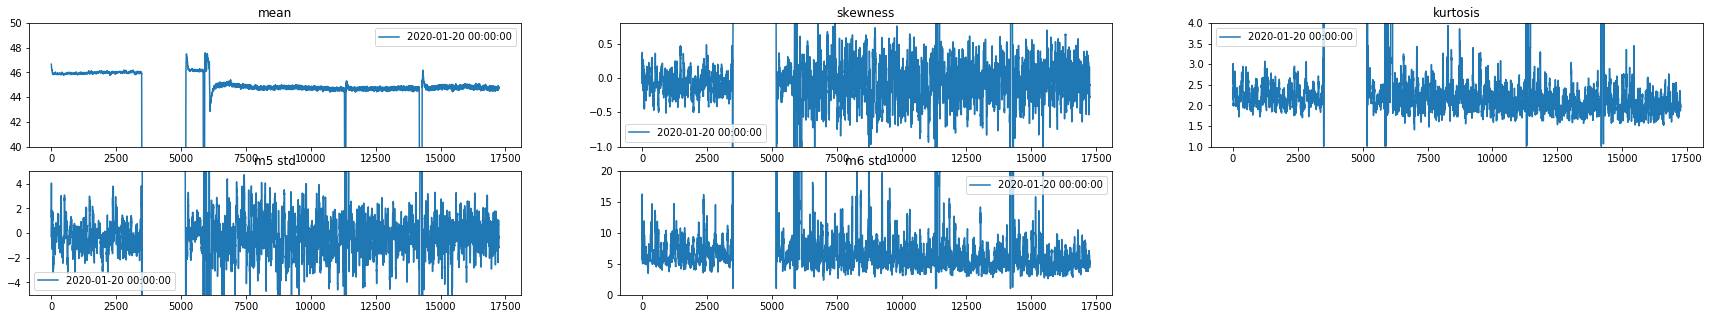

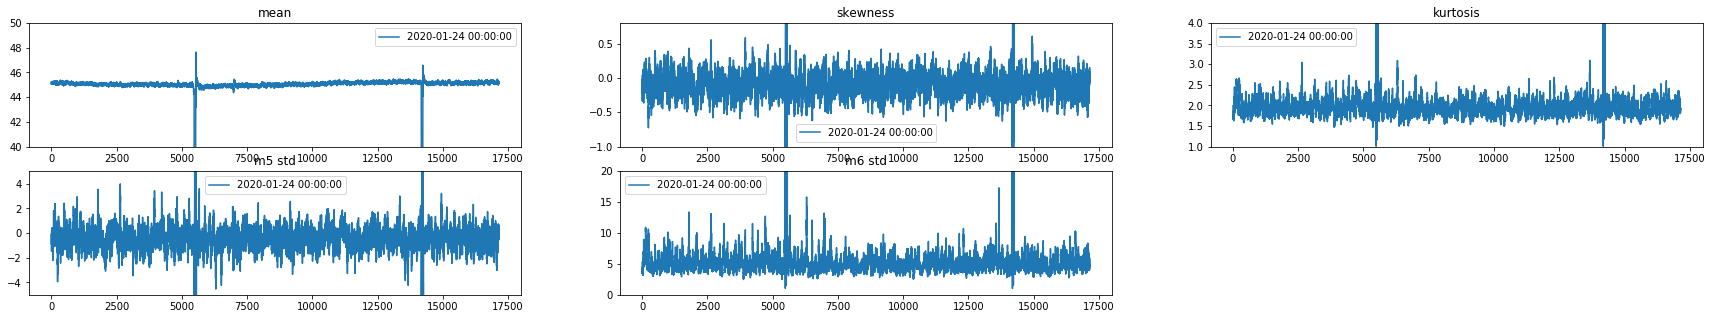

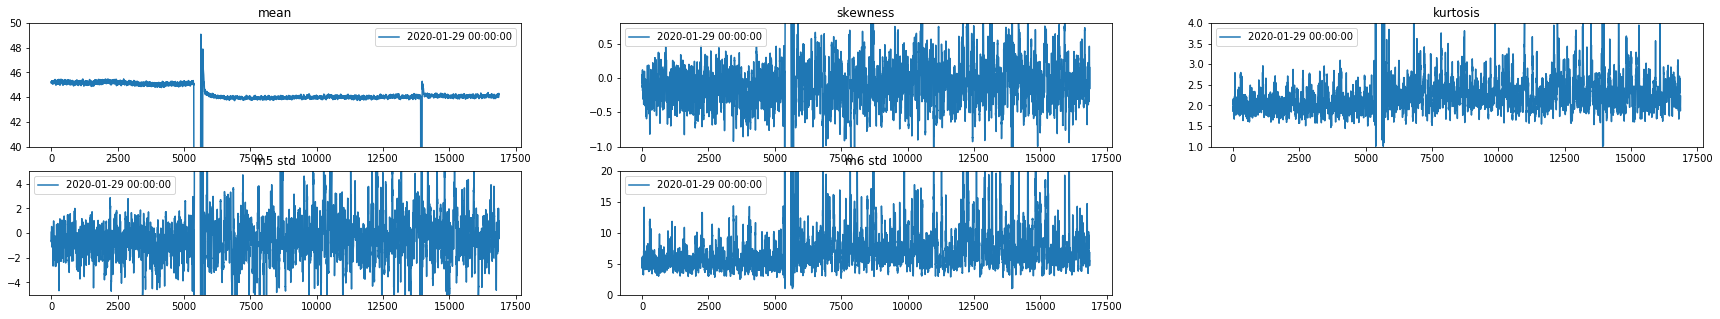

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(len(m_df)):
    plt.figure(figsize=([30,5]))
    plt.subplot(2,3,1)
    plt.plot(m_df[i]['mean'], label = str(data[i].index[0]))
    plt.ylim([40,50])
    plt.legend()
    plt.title('mean')
    plt.subplot(2,3,2)
    plt.plot(m_df[i]['skewness'], label = str(data[i].index[0]))
    plt.ylim([-1,0.8])
    plt.legend()
    plt.title('skewness')
    plt.subplot(2,3,3)
    plt.plot(m_df[i]['kurtosis'], label = str(data[i].index[0]))
    plt.ylim([1,4])
    plt.legend()
    plt.title('kurtosis')
    plt.subplot(2,3,4)
    plt.plot(m_df[i]['m5_std'], label = str(data[i].index[0]))
    plt.legend()
    plt.ylim([-5,5])
    plt.title('m5 std')
    plt.subplot(2,3,5)
    plt.plot(m_df[i]['m6_std'], label = str(data[i].index[0]))
    plt.legend()
    plt.ylim([0,20])
    plt.title('m6 std')


In [83]:
stats.skew(t)

0.2650554122698573

In [84]:
m3 = stats.moment(t,moment=3)
m2 = stats.moment(t,moment=2)
s = m3/(m2)**(3/2)
s

0.2650554122698573